# Sentiment Analysis - Armin Abbasi Najarzadeh / Advanced AI / Final Project

## Types
- `FeatureVector: Dict[str, int]`: A dictionary with words as keys and the frequency of which they are repeated in a sentence as values.
- `WeightVector: Dict[str, float]`: A dictionary with words as keys and their corresponding weight as values.
- `Example: Tuple[FeatureVector, int]`: A tuple of phi (feature vector) and it's label denoting it's positivity +1 or negativity -1.
- `T: TypeVar('T')`: Generic type

## Functions
- **Problem 3a: Feature Extraction**
    - `extract_word_Features()`:<br> 
        &emsp;Extract word features for a string x. Words are delimited by whitespace characters only.

- **Problem 3b: Stochastic Gradient Descent**
    - `learn_predictor()`:<br> 
        &emsp;Given `train_examples` and `val_examples` (each one is a list of (x,y) pairs), a `feature_extractor` to apply to x,<br>&emsp;and the number of epochs to train `num_epochs`, the step size `eta`, return the weight vector (sparse feature vector) learned.

- **Problem 3c: Generate Dummy Data**
    - `generate_dataset()`:<br> 
        &emsp;Return a set of examples (phi(x), y) randomly which are classified correctly by `weights`.

- **Problem 3d: Character Features**
    - `extract_character_features()`:<br> 
        &emsp;Return a function that takes a string `x` and returns a sparse feature vector consisting of all n-grams of `x` without spaces mapped to their n-gram counts.<br>&emsp;EXAMPLE: (n = 3) "I like tacos" --> {'Ili': 1, 'lik': 1 'ike': 1, ... You may assume that n >= 1.

- **Problem 3e: n-grams Testing**
    - `test_values_n()`:<br>
        &emsp;Test different values of n for extractCharacterFeatures

# Importing Libraries

In [1]:
import json
import random
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Callable, Dict, List, Tuple, TypeVar

# Custom Types

In [2]:
FeatureVector = Dict[str, int]
WeightVector = Dict[str, float]
Example = Tuple[FeatureVector, int]
T = TypeVar('T')

# Utility Functions

In [3]:
def dotProduct(d1, d2):
    return dotProduct(d2, d1) if len(d1) < len(d2) else sum(d1.get(f, 0) * v for f, v in list(d2.items()))


def readExamples(path):
    examples = []
    for line in open(path, "rb"):
        line = line.decode('latin-1')
        y, x = line.split(' ', 1)
        examples.append((x.strip(), int(y)))

    print(f"Read {len(examples)} examples from {path}")

    return examples


def evaluatePredictor(examples, predictor):
    error = 0
    for x, y in examples:
        error += int(predictor(x) != y)

    return 1.0 * error / len(examples)


def saveWeights(weights, path):
    print(f"Saving {len(weights)} weights to {path}.")

    json_object = json.dumps(weights, indent=4)

    with open(path, "w") as outfile:
        outfile.write(json_object)


def loadWeights(path):
    with open(path, 'r') as file:
        json_object = json.load(file)

    return dict(json_object)


def verbosePredict(phi, y, weights, out):
    yy = 1 if dotProduct(phi, weights) >= 0 else -1

    if y:
        print(f"Truth: {y}, Prediction: {yy} [{'CORRECT' if y == yy else 'WRONG'}]", file=out)

    else:
        print("Prediction:", yy, file=out)

    for f, v in sorted(list(phi.items()), key=lambda f_v1: -f_v1[1] * weights.get(f_v1[0], 0)):
        w = weights.get(f, 0)
        print(f"{f:<30}{v} * {w} = {v * w}", file=out)

    return yy


def outputErrorAnalysis(examples, featureExtractor, weights, path):
    print(f"Writing Error Analysis to {path}")
    out = open(path, 'w', encoding='utf-8')
    for x, y in examples:
        print('===', x, file=out)
        verbosePredict(featureExtractor(x), y, weights, out)

    out.close()

# Main Functions

In [4]:
def extract_word_features(x: str) -> FeatureVector:
    features = {}

    for word in x.split():
        features[word] = features.get(word, 0) + 1

    return features

In [5]:
def learn_predictor(train_examples: List[Tuple[T, int]],
                   val_examples: List[Tuple[T, int]],
                   feature_extractor: Callable[[T], FeatureVector],
                   num_epochs: int, eta: float) -> Tuple[WeightVector, List[float], List[float]]:

    weights = {}
    train_losses = []
    val_losses = []

    def predictor(x):
        return 1 if dotProduct(feature_extractor(x), weights) >= 0 else -1

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0

        for datapoint in train_examples:
            review, label = datapoint

            features = feature_extractor(review)
            hinge = dotProduct(features, weights) * label

            train_loss += int(predictor(review) != label)

            if hinge < 1.0:
                for feature in features:
                    gradient = (-1 * features[feature]) * label
                    weights[feature] = weights.get(feature, 0) - eta * (gradient)

        for datapoint in val_examples:
            review, label = datapoint

            features = feature_extractor(review)
            hinge = dotProduct(features, weights) * label

            val_loss += int(predictor(review) != label)

        train_loss /= len(train_examples)
        val_loss /= len(val_examples)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}:")
        print(f"Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}\n")

    return weights, train_losses, val_losses

In [27]:
def generate_dataset(num_examples: int, weights: WeightVector) -> List[Example]:
    print(f"Generating {num_examples} dummy data.")
    def generate_example() -> Tuple[str, int]:
        phi = {random.choice(list(weights.keys())) : random.randrange(0, 10) for _ in range(random.randrange(2, 30))}
        y = 1 if dotProduct(phi, weights) >= 0 else -1

        x = []

        for word in phi.keys():
          for _ in range(phi[word]):
            x.append(word)

        return " ".join(x), y

    return [generate_example() for _ in range(num_examples)]

In [7]:
def extract_character_features(n: int) -> Callable[[str], FeatureVector]:
    def extract(x: str) -> Dict[str, int]:
        spaceless = x.replace(" ", "")
        features = {}

        for i in range(len(spaceless) - n + 1):
            ngram = spaceless[i:i+n]
            features[ngram] = features.get(ngram, 0) + 1

        return features

    return extract

In [9]:
def draw_cross_validation(train_losses, val_losses):
    plt.figure(figsize=(10, 6))

    plt.plot(train_losses, label="Training")
    plt.plot(val_losses, label="Valdation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [ ]:
def test_values_n(ngram: int,
                  train_examples: List,
                  val_examples: List,
                  num_epochs: int,
                  eta: float):
    
    print(f"\n\nTesting prediction with model trained using character feature extractor with ngram = {ngram}.")

    feature_extractor = extract_character_features(ngram)

    weights, train_losses, val_losses = learn_predictor(train_examples,
                                                        val_examples,
                                                        feature_extractor,
                                                        num_epochs,
                                                        eta)

    outputErrorAnalysis(val_examples, feature_extractor, weights, 'error-analysis')

    train_error = evaluatePredictor(
        train_examples, lambda x:
        (1 if dotProduct(feature_extractor(x), weights) >= 0 else -1))

    val_error = evaluatePredictor(
        val_examples, lambda x:
        (1 if dotProduct(feature_extractor(x), weights) >= 0 else -1))

    print((f"Official: Train Error = {train_error}, Validation Error = {val_error}\n"))

    draw_cross_validation(train_losses, val_losses)

## Training and Testing the Model



### Setting Dataset (Training Set and Validation Set) Paths

In [10]:
trainset_path = Path('polarity.train')
valset_path = Path('polarity.dev')

### Loading Training and Validation Examples


In [11]:
train_examples = readExamples(trainset_path)
val_examples = readExamples(valset_path)

Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev


### Setting Hyperparameters

In [32]:
num_epochs = 20
eta = 0.01

### Training the Model on Loaded Data



In [33]:
weights, train_losses, val_losses = learn_predictor(train_examples,
                                                    val_examples,
                                                    extract_word_features,
                                                    num_epochs,
                                                    eta)

saveWeights(weights, 'true_weights.json')

Epoch 1:
Train loss: 0.4167 | Validation loss: 0.3509

Epoch 2:
Train loss: 0.2957 | Validation loss: 0.3236

Epoch 3:
Train loss: 0.2316 | Validation loss: 0.3104

Epoch 4:
Train loss: 0.1908 | Validation loss: 0.2988

Epoch 5:
Train loss: 0.1609 | Validation loss: 0.2915

Epoch 6:
Train loss: 0.1407 | Validation loss: 0.2862

Epoch 7:
Train loss: 0.1199 | Validation loss: 0.2831

Epoch 8:
Train loss: 0.1097 | Validation loss: 0.2766

Epoch 9:
Train loss: 0.0923 | Validation loss: 0.2831

Epoch 10:
Train loss: 0.0853 | Validation loss: 0.2825

Epoch 11:
Train loss: 0.0785 | Validation loss: 0.2788

Epoch 12:
Train loss: 0.0689 | Validation loss: 0.2831

Epoch 13:
Train loss: 0.0591 | Validation loss: 0.2721

Epoch 14:
Train loss: 0.0515 | Validation loss: 0.2766

Epoch 15:
Train loss: 0.0490 | Validation loss: 0.2766

Epoch 16:
Train loss: 0.0453 | Validation loss: 0.2712

Epoch 17:
Train loss: 0.0419 | Validation loss: 0.2729

Epoch 18:
Train loss: 0.0397 | Validation loss: 0.2735

E

Drawing the Cross Validation Plot

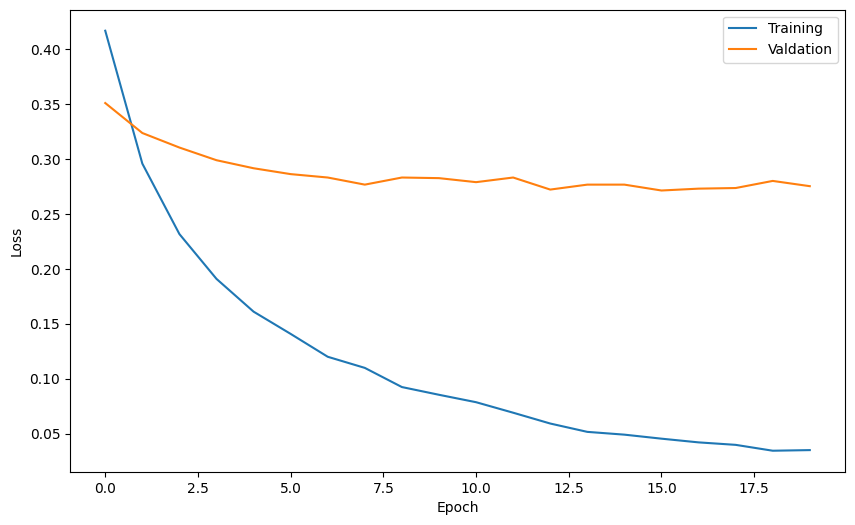

In [34]:
draw_cross_validation(train_losses, val_losses)

### Training the Model on Loaded Data + Generated Dummy Data

In [35]:
num_examples = 10000
pretrained_weights = loadWeights('true_weights.json')

augmented_train_examples = train_examples + generate_dataset(num_examples, pretrained_weights)

weights, train_losses, val_losses = learn_predictor(augmented_train_examples,
                                                    val_examples,
                                                    extract_word_features,
                                                    num_epochs,
                                                    eta)

saveWeights(weights, 'augmented_weights.json')

Generating 10000 dummy data.
Epoch 1:
Train loss: 0.3381 | Validation loss: 0.3275

Epoch 2:
Train loss: 0.1039 | Validation loss: 0.2971

Epoch 3:
Train loss: 0.0447 | Validation loss: 0.2909

Epoch 4:
Train loss: 0.0256 | Validation loss: 0.2859

Epoch 5:
Train loss: 0.0193 | Validation loss: 0.2811

Epoch 6:
Train loss: 0.0153 | Validation loss: 0.2839

Epoch 7:
Train loss: 0.0131 | Validation loss: 0.2890

Epoch 8:
Train loss: 0.0117 | Validation loss: 0.2757

Epoch 9:
Train loss: 0.0110 | Validation loss: 0.2797

Epoch 10:
Train loss: 0.0094 | Validation loss: 0.2766

Epoch 11:
Train loss: 0.0094 | Validation loss: 0.2766

Epoch 12:
Train loss: 0.0080 | Validation loss: 0.2715

Epoch 13:
Train loss: 0.0075 | Validation loss: 0.2752

Epoch 14:
Train loss: 0.0073 | Validation loss: 0.2701

Epoch 15:
Train loss: 0.0066 | Validation loss: 0.2721

Epoch 16:
Train loss: 0.0061 | Validation loss: 0.2710

Epoch 17:
Train loss: 0.0058 | Validation loss: 0.2772

Epoch 18:
Train loss: 0.0055

Drawing the Cross Validation Plot

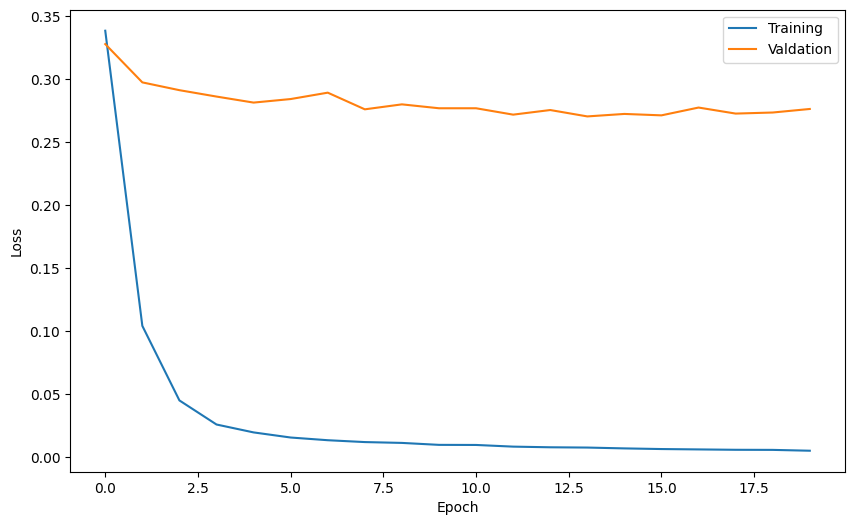

In [36]:
draw_cross_validation(train_losses, val_losses)



Testing prediction with model trained using character feature extractor with ngram = 2.
Epoch 1:
Train loss: 0.4094 | Validation loss: 0.4131

Epoch 2:
Train loss: 0.3610 | Validation loss: 0.4043

Epoch 3:
Train loss: 0.3469 | Validation loss: 0.3925

Epoch 4:
Train loss: 0.3354 | Validation loss: 0.4063

Epoch 5:
Train loss: 0.3213 | Validation loss: 0.4021

Epoch 6:
Train loss: 0.3154 | Validation loss: 0.4060

Epoch 7:
Train loss: 0.3115 | Validation loss: 0.4207

Epoch 8:
Train loss: 0.3106 | Validation loss: 0.4114

Epoch 9:
Train loss: 0.3070 | Validation loss: 0.4209

Epoch 10:
Train loss: 0.3008 | Validation loss: 0.4212

Epoch 11:
Train loss: 0.3011 | Validation loss: 0.4184

Epoch 12:
Train loss: 0.2971 | Validation loss: 0.4235

Epoch 13:
Train loss: 0.2859 | Validation loss: 0.4007

Epoch 14:
Train loss: 0.2901 | Validation loss: 0.4091

Epoch 15:
Train loss: 0.2817 | Validation loss: 0.4173

Epoch 16:
Train loss: 0.2870 | Validation loss: 0.4057

Epoch 17:
Train loss: 0

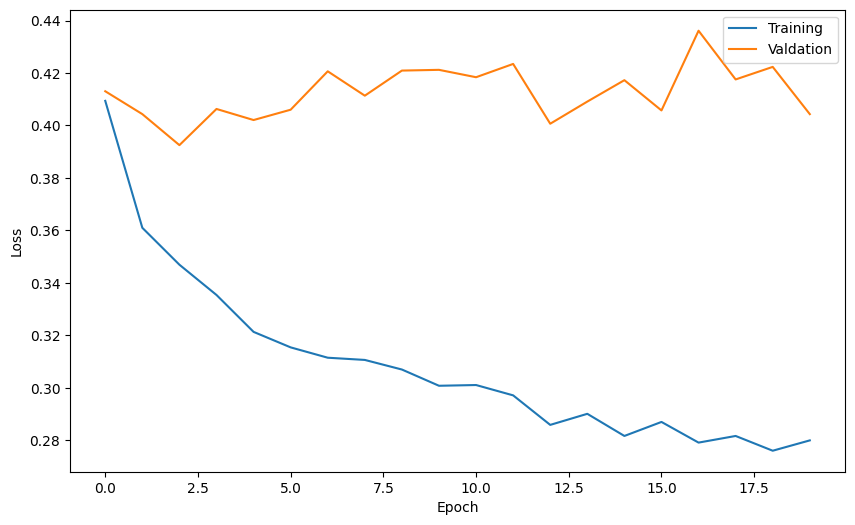



Testing prediction with model trained using character feature extractor with ngram = 3.
Epoch 1:
Train loss: 0.3661 | Validation loss: 0.3562

Epoch 2:
Train loss: 0.2085 | Validation loss: 0.3337

Epoch 3:
Train loss: 0.1531 | Validation loss: 0.3337

Epoch 4:
Train loss: 0.1137 | Validation loss: 0.3154

Epoch 5:
Train loss: 0.0858 | Validation loss: 0.3222

Epoch 6:
Train loss: 0.0712 | Validation loss: 0.3177

Epoch 7:
Train loss: 0.0574 | Validation loss: 0.3134

Epoch 8:
Train loss: 0.0447 | Validation loss: 0.3151

Epoch 9:
Train loss: 0.0371 | Validation loss: 0.3174

Epoch 10:
Train loss: 0.0279 | Validation loss: 0.3120

Epoch 11:
Train loss: 0.0248 | Validation loss: 0.3134

Epoch 12:
Train loss: 0.0180 | Validation loss: 0.3185

Epoch 13:
Train loss: 0.0141 | Validation loss: 0.3182

Epoch 14:
Train loss: 0.0115 | Validation loss: 0.3191

Epoch 15:
Train loss: 0.0090 | Validation loss: 0.3154

Epoch 16:
Train loss: 0.0082 | Validation loss: 0.3194

Epoch 17:
Train loss: 0

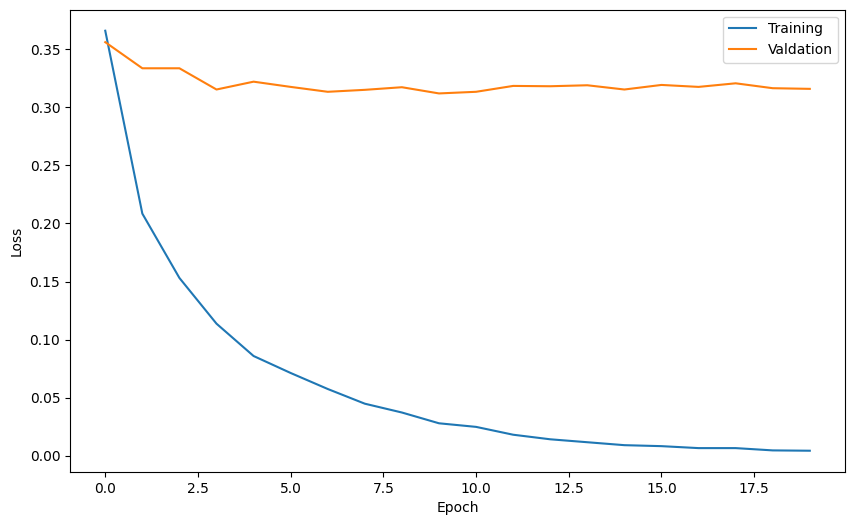



Testing prediction with model trained using character feature extractor with ngram = 4.
Epoch 1:
Train loss: 0.3362 | Validation loss: 0.2794

Epoch 2:
Train loss: 0.1041 | Validation loss: 0.2814

Epoch 3:
Train loss: 0.0363 | Validation loss: 0.2794

Epoch 4:
Train loss: 0.0124 | Validation loss: 0.2777

Epoch 5:
Train loss: 0.0062 | Validation loss: 0.2788

Epoch 6:
Train loss: 0.0034 | Validation loss: 0.2788

Epoch 7:
Train loss: 0.0017 | Validation loss: 0.2817

Epoch 8:
Train loss: 0.0008 | Validation loss: 0.2788

Epoch 9:
Train loss: 0.0006 | Validation loss: 0.2811

Epoch 10:
Train loss: 0.0003 | Validation loss: 0.2817

Epoch 11:
Train loss: 0.0003 | Validation loss: 0.2808

Epoch 12:
Train loss: 0.0000 | Validation loss: 0.2800

Epoch 13:
Train loss: 0.0000 | Validation loss: 0.2788

Epoch 14:
Train loss: 0.0000 | Validation loss: 0.2817

Epoch 15:
Train loss: 0.0000 | Validation loss: 0.2817

Epoch 16:
Train loss: 0.0000 | Validation loss: 0.2797

Epoch 17:
Train loss: 0

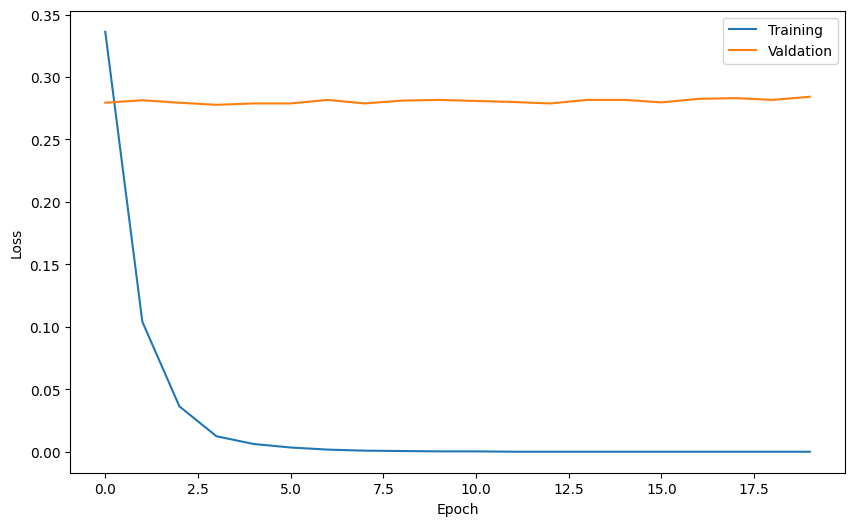



Testing prediction with model trained using character feature extractor with ngram = 5.
Epoch 1:
Train loss: 0.3331 | Validation loss: 0.2788

Epoch 2:
Train loss: 0.0571 | Validation loss: 0.2797

Epoch 3:
Train loss: 0.0118 | Validation loss: 0.2735

Epoch 4:
Train loss: 0.0028 | Validation loss: 0.2712

Epoch 5:
Train loss: 0.0023 | Validation loss: 0.2693

Epoch 6:
Train loss: 0.0008 | Validation loss: 0.2724

Epoch 7:
Train loss: 0.0008 | Validation loss: 0.2774

Epoch 8:
Train loss: 0.0003 | Validation loss: 0.2743

Epoch 9:
Train loss: 0.0000 | Validation loss: 0.2769

Epoch 10:
Train loss: 0.0000 | Validation loss: 0.2752

Epoch 11:
Train loss: 0.0000 | Validation loss: 0.2743

Epoch 12:
Train loss: 0.0000 | Validation loss: 0.2755

Epoch 13:
Train loss: 0.0000 | Validation loss: 0.2732

Epoch 14:
Train loss: 0.0000 | Validation loss: 0.2727

Epoch 15:
Train loss: 0.0000 | Validation loss: 0.2732

Epoch 16:
Train loss: 0.0000 | Validation loss: 0.2735

Epoch 17:
Train loss: 0

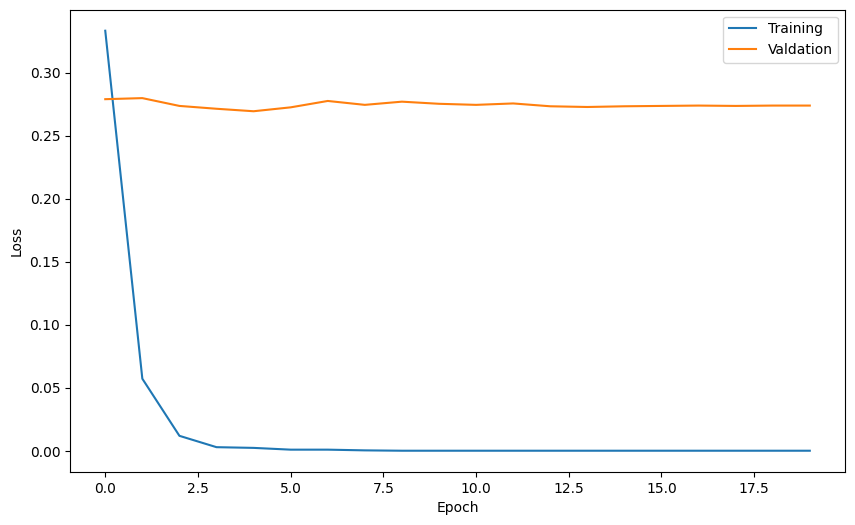



Testing prediction with model trained using character feature extractor with ngram = 6.
Epoch 1:
Train loss: 0.3329 | Validation loss: 0.2923

Epoch 2:
Train loss: 0.0290 | Validation loss: 0.2786

Epoch 3:
Train loss: 0.0059 | Validation loss: 0.2752

Epoch 4:
Train loss: 0.0020 | Validation loss: 0.2772

Epoch 5:
Train loss: 0.0008 | Validation loss: 0.2729

Epoch 6:
Train loss: 0.0003 | Validation loss: 0.2732

Epoch 7:
Train loss: 0.0003 | Validation loss: 0.2718

Epoch 8:
Train loss: 0.0000 | Validation loss: 0.2724

Epoch 9:
Train loss: 0.0000 | Validation loss: 0.2752

Epoch 10:
Train loss: 0.0000 | Validation loss: 0.2752

Epoch 11:
Train loss: 0.0000 | Validation loss: 0.2735

Epoch 12:
Train loss: 0.0000 | Validation loss: 0.2732

Epoch 13:
Train loss: 0.0000 | Validation loss: 0.2727

Epoch 14:
Train loss: 0.0000 | Validation loss: 0.2732

Epoch 15:
Train loss: 0.0000 | Validation loss: 0.2741

Epoch 16:
Train loss: 0.0000 | Validation loss: 0.2749

Epoch 17:
Train loss: 0

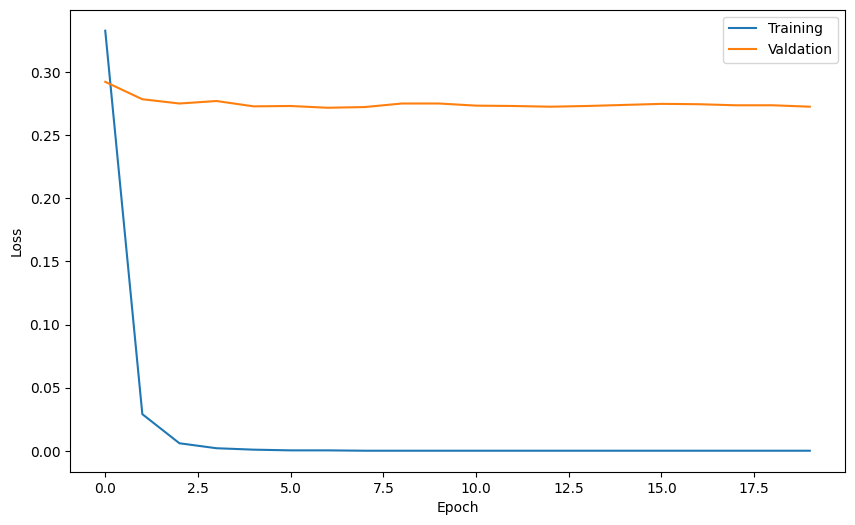



Testing prediction with model trained using character feature extractor with ngram = 7.
Epoch 1:
Train loss: 0.3461 | Validation loss: 0.2988

Epoch 2:
Train loss: 0.0160 | Validation loss: 0.2814

Epoch 3:
Train loss: 0.0031 | Validation loss: 0.2763

Epoch 4:
Train loss: 0.0014 | Validation loss: 0.2681

Epoch 5:
Train loss: 0.0006 | Validation loss: 0.2707

Epoch 6:
Train loss: 0.0003 | Validation loss: 0.2718

Epoch 7:
Train loss: 0.0003 | Validation loss: 0.2715

Epoch 8:
Train loss: 0.0003 | Validation loss: 0.2712

Epoch 9:
Train loss: 0.0003 | Validation loss: 0.2718

Epoch 10:
Train loss: 0.0003 | Validation loss: 0.2715

Epoch 11:
Train loss: 0.0003 | Validation loss: 0.2718

Epoch 12:
Train loss: 0.0003 | Validation loss: 0.2701

Epoch 13:
Train loss: 0.0003 | Validation loss: 0.2707

Epoch 14:
Train loss: 0.0003 | Validation loss: 0.2707

Epoch 15:
Train loss: 0.0003 | Validation loss: 0.2710

Epoch 16:
Train loss: 0.0003 | Validation loss: 0.2710

Epoch 17:
Train loss: 0

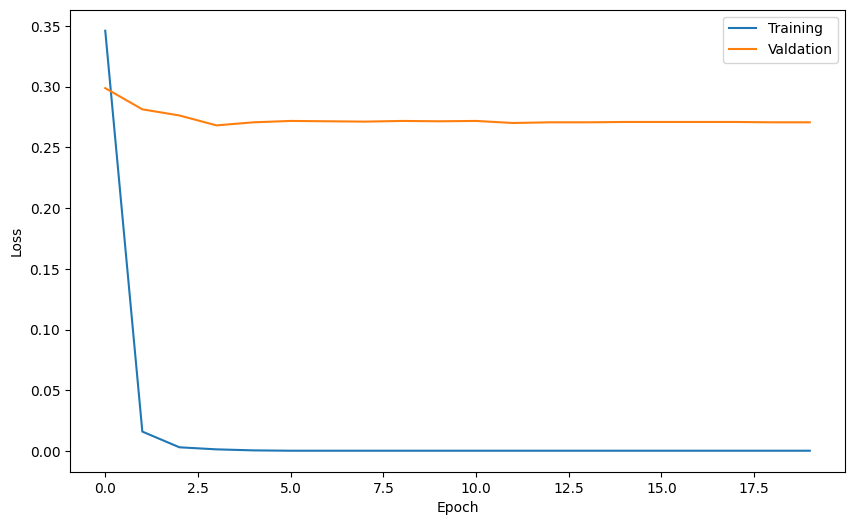



Testing prediction with model trained using character feature extractor with ngram = 8.
Epoch 1:
Train loss: 0.3658 | Validation loss: 0.3008

Epoch 2:
Train loss: 0.0104 | Validation loss: 0.2985

Epoch 3:
Train loss: 0.0028 | Validation loss: 0.2918

Epoch 4:
Train loss: 0.0008 | Validation loss: 0.2940

Epoch 5:
Train loss: 0.0006 | Validation loss: 0.2907

Epoch 6:
Train loss: 0.0006 | Validation loss: 0.2926

Epoch 7:
Train loss: 0.0006 | Validation loss: 0.2918

Epoch 8:
Train loss: 0.0006 | Validation loss: 0.2915

Epoch 9:
Train loss: 0.0006 | Validation loss: 0.2926

Epoch 10:
Train loss: 0.0006 | Validation loss: 0.2935

Epoch 11:
Train loss: 0.0006 | Validation loss: 0.2921

Epoch 12:
Train loss: 0.0006 | Validation loss: 0.2921

Epoch 13:
Train loss: 0.0006 | Validation loss: 0.2918

Epoch 14:
Train loss: 0.0006 | Validation loss: 0.2918

Epoch 15:
Train loss: 0.0006 | Validation loss: 0.2921

Epoch 16:
Train loss: 0.0006 | Validation loss: 0.2923

Epoch 17:
Train loss: 0

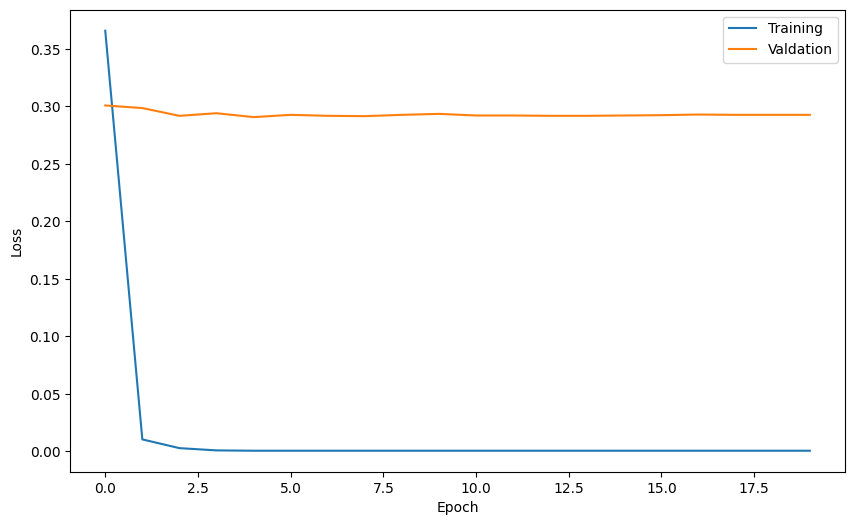



Testing prediction with model trained using character feature extractor with ngram = 9.
Epoch 1:
Train loss: 0.3765 | Validation loss: 0.3188

Epoch 2:
Train loss: 0.0073 | Validation loss: 0.3160

Epoch 3:
Train loss: 0.0023 | Validation loss: 0.3109

Epoch 4:
Train loss: 0.0011 | Validation loss: 0.3095

Epoch 5:
Train loss: 0.0008 | Validation loss: 0.3095

Epoch 6:
Train loss: 0.0008 | Validation loss: 0.3075

Epoch 7:
Train loss: 0.0008 | Validation loss: 0.3064

Epoch 8:
Train loss: 0.0008 | Validation loss: 0.3073

Epoch 9:
Train loss: 0.0008 | Validation loss: 0.3070

Epoch 10:
Train loss: 0.0008 | Validation loss: 0.3075

Epoch 11:
Train loss: 0.0008 | Validation loss: 0.3081

Epoch 12:
Train loss: 0.0008 | Validation loss: 0.3087

Epoch 13:
Train loss: 0.0008 | Validation loss: 0.3098

Epoch 14:
Train loss: 0.0008 | Validation loss: 0.3098

Epoch 15:
Train loss: 0.0008 | Validation loss: 0.3098

Epoch 16:
Train loss: 0.0008 | Validation loss: 0.3098

Epoch 17:
Train loss: 0

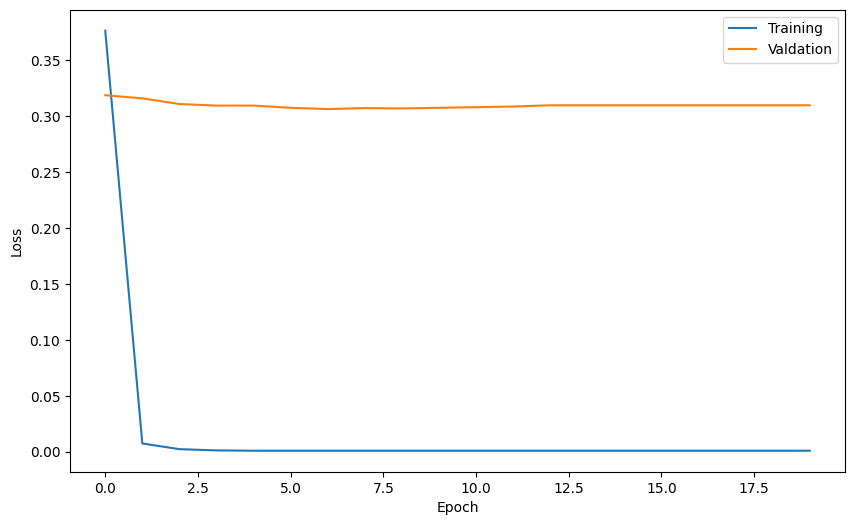

In [41]:
for ngram in range(2, 10):
    test_values_n(ngram, train_examples, val_examples, num_epochs, eta)

# Insights Gathered from Examination of Validation Losses Across Models Using Character Feature Extractor (n-grams) vs. Word Feature Extractor (freq count)

The optimal value for `n` in the model utilizing character feature extractor (n-grams) appears to be 7, as it yields the lowest validation error. The validation error shows a decreasing trend from `n = 2` to `n = 7`, after which it begins to rise again.

The dataset contains numerous long words in the reviews. Therefore, the 7-character sequences are likely the most common in both the validation and training datasets, leading to a higher match rate and subsequently, a lower error rate.

As could be observed upon close inspection, comparing validation loss of models with word extractors and character extractors, character n-grams are likely to be more effective than word features, especially in cases where a positive review contains multiple double negations, or vice versa. This is because the weights assigned to individual words can differ significantly from the weights assigned to character n-grams. The semantic meaning of words when used in isolation can be quite different from their meaning when used in conjunction, as word features completely disregards this important feature of the language then character n-grams potentially possesses higher accuracy.
